# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.

### Get the data
You'll be using two datasets in this project:
MNIST
CelebA
Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA. Running the GANs on MNIST will allow you to see how well your model trains sooner.
If you're using FloydHub, set data_dir to "/input" and use the FloydHub data ID "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = './input'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the MNIST dataset contains images of handwritten digits. You can view the first number of examples by changing show_n_images.

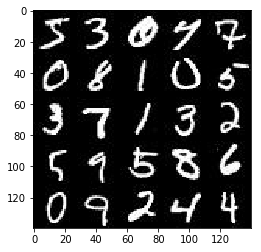

In [2]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The CelebFaces Attributes Dataset (CelebA) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations. You can view the first number of examples by changing show_n_images.

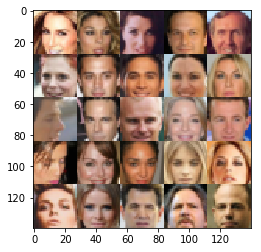

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you. The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images. The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single color channel while the CelebA images have 3 color channels (RGB color channel).

## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
* model_inputs
* discriminator
* generator
* model_loss
* model_opt
* train

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/krypten/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the model_inputs function to create TF Placeholders for the Neural Network. It should create the following placeholders:
* Real input images placeholder with rank 4 using image_width, image_height, and image_channels.
* Z input placeholder with rank 2 using z_dim.
* Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='z_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_data = tf.placeholder(tf.float32, name='learning_data')
    
    return real_input, z_input, learning_data

tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement discriminator to create a discriminator neural network that discriminates on images. This function should be able to reuse the variables in the neural network. Use tf.variable_scope with a scope name of "discriminator" to allow the variables to be reused. The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, rate=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input Layer : (28x28x3)
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        h1 = tf.maximum(alpha * h1, h1)
        # Hidden Layer 1 : (14x14x64)
        h2 = tf.layers.conv2d(h1, 128, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        h2 = tf.maximum(alpha * h2, h2)
        h2 = tf.layers.dropout(h2, rate=rate)
        # Hidden Layer 2 : (14x14x256)
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        h3 = tf.maximum(alpha * h3, h3)
        # Hidden Layer 3 : (7x7x256)
        flat = tf.reshape(h3, (-1, 7*7*256))
        # Flat layer : (7*7*256)
        logits = tf.layers.dense(flat, 1)
        
        output = tf.sigmoid(logits)
        
        return output, logits

tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement generator to generate an image using z. This function should be able to reuse the variables in the neural network. Use tf.variable_scope with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x out_channel_dim images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, rate=0.1):
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        h1 = tf.layers.dense(z, 7 * 7 * 256)

        # Reshape it to start the convolution network
        h1 = tf.reshape(h1, (-1, 7, 7, 256))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1) # LRelu
        # Hidden Layer 1 : (7x7x256)

        h2 = tf.layers.conv2d_transpose(h1, 128, 5, strides=1, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        # Hidden Layer 2 : (7x7x128)
        
        h3 = tf.layers.conv2d_transpose(h2, 64, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        h3 = tf.layers.dropout(h3, rate=rate, training=is_train)
        # Hidden Layer 3 : (14x14x64)
        
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, strides=2, padding='same')
        # Output Layer : (28x28x3)
        
        output = tf.tanh(logits)
        return output

tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement model_loss to build the GANs for training and calculate the loss. The function should return a tuple of (discriminator loss, generator loss). Use the following functions you implemented:
* discriminator(images, reuse=False)
* generator(z, out_channel_dim, is_train=True)

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Losses
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement model_opt to create the optimization operations for the GANs. Use tf.trainable_variables to get all the trainable variables. Filter the variables with names that are in the discriminator and generator scope names. The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    # Trainable Variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
        return d_train_opt, g_train_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})
    
    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement train to build and train the GANs. Use the following functions you implemented:
* model_inputs(image_width, image_height, image_channels, z_dim)
* model_loss(input_real, input_z, out_channel_dim)
* model_opt(d_loss, g_loss, learning_rate, beta1)

Use the show_generator_output to show generator output while you train. Running show_generator_output for every batch will drastically increase training time and increase the size of the notebook. It's recommended to print the generator output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, show_every=100, n_images=25):
    steps = 0
    # Define Image dimensions
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    # Define model
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Input
                batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run Optimizers
                _ = sess.run(d_train_opt, feed_dict={
                    input_real: batch_images,
                    input_z:    batch_z,
                    lr:         learning_rate
                })
                _ = sess.run(g_train_opt, feed_dict={
                    input_real: batch_images,
                    input_z:    batch_z,
                    lr:         learning_rate
                })
                
                # Show generator output
                if (steps % show_every == 0):
                    # Plot generator output
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                if (steps % 10 == 0):
                    # Get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}/{}...".format(steps % batch_size, batch_size),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                steps += 1  

### MNIST
Test your GANs architecture on MNIST. After 2 epochs, the GANs should be able to generate images that look like handwritten digits. Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

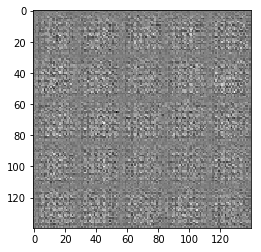

Epoch 1/2... Batch 0/32... Discriminator Loss: 1.2403... Generator Loss: 0.5951
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.2645... Generator Loss: 0.6275
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.4122... Generator Loss: 0.4330
Epoch 1/2... Batch 30/32... Discriminator Loss: 2.1589... Generator Loss: 1.7602
Epoch 1/2... Batch 8/32... Discriminator Loss: 1.0805... Generator Loss: 0.8307
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.2480... Generator Loss: 0.7694
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.1916... Generator Loss: 0.7201
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.2667... Generator Loss: 0.7727
Epoch 1/2... Batch 16/32... Discriminator Loss: 1.3516... Generator Loss: 0.8933
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.3507... Generator Loss: 0.7648


Epoch 1/2... Batch 4/32... Discriminator Loss: 1.3768... Generator Loss: 0.9137
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.3797... Generator Loss: 0.7740
Epoch 1/2... Batch 24/32... Discriminator Loss: 1.2863... Generator Loss: 0.7348
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.4140... Generator Loss: 1.2082
Epoch 1/2... Batch 12/32... Discriminator Loss: 1.3586... Generator Loss: 0.7176
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.3547... Generator Loss: 0.6590
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.3800... Generator Loss: 0.7729
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.3499... Generator Loss: 0.6982
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.3738... Generator Loss: 0.6998
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.4005... Generator Loss: 0.5467


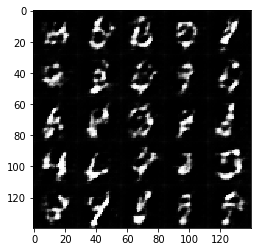

Epoch 1/2... Batch 8/32... Discriminator Loss: 1.2882... Generator Loss: 1.0395
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.6140... Generator Loss: 0.4045
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.3343... Generator Loss: 0.5998
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.3918... Generator Loss: 0.6750
Epoch 1/2... Batch 16/32... Discriminator Loss: 1.4475... Generator Loss: 0.8057
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.2704... Generator Loss: 0.7893
Epoch 1/2... Batch 4/32... Discriminator Loss: 1.4211... Generator Loss: 0.5759
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.5332... Generator Loss: 0.5117
Epoch 1/2... Batch 24/32... Discriminator Loss: 1.4042... Generator Loss: 0.8894
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.3319... Generator Loss: 0.8799


Epoch 1/2... Batch 12/32... Discriminator Loss: 1.5914... Generator Loss: 0.9338
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.2653... Generator Loss: 0.9367
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.5042... Generator Loss: 0.4677
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.3716... Generator Loss: 0.9371
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.3282... Generator Loss: 0.8897
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.2504... Generator Loss: 0.6922
Epoch 1/2... Batch 8/32... Discriminator Loss: 1.3157... Generator Loss: 0.8195
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.3344... Generator Loss: 0.9341
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.3436... Generator Loss: 0.7733
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.7093... Generator Loss: 0.3309


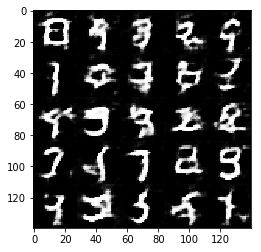

Epoch 1/2... Batch 16/32... Discriminator Loss: 1.4299... Generator Loss: 1.0399
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.5000... Generator Loss: 0.8613
Epoch 1/2... Batch 4/32... Discriminator Loss: 1.2967... Generator Loss: 0.8140
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.3431... Generator Loss: 0.7442
Epoch 1/2... Batch 24/32... Discriminator Loss: 1.3666... Generator Loss: 0.8766
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.3650... Generator Loss: 0.6754
Epoch 1/2... Batch 12/32... Discriminator Loss: 1.3478... Generator Loss: 0.8112
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.3300... Generator Loss: 0.7419
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.4228... Generator Loss: 0.5803
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.2311... Generator Loss: 1.2998


Epoch 1/2... Batch 20/32... Discriminator Loss: 1.3484... Generator Loss: 0.6981
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.3561... Generator Loss: 0.8131
Epoch 1/2... Batch 8/32... Discriminator Loss: 1.4470... Generator Loss: 0.6791
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.3608... Generator Loss: 0.7286
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.2888... Generator Loss: 0.8433
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.3150... Generator Loss: 0.8357
Epoch 1/2... Batch 16/32... Discriminator Loss: 1.3156... Generator Loss: 0.6674
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.2753... Generator Loss: 0.7489
Epoch 1/2... Batch 4/32... Discriminator Loss: 1.3703... Generator Loss: 1.1516
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.3191... Generator Loss: 0.7861


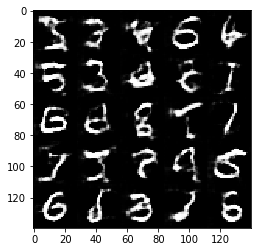

Epoch 1/2... Batch 24/32... Discriminator Loss: 1.3589... Generator Loss: 0.7381
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.2550... Generator Loss: 0.8055
Epoch 1/2... Batch 12/32... Discriminator Loss: 1.3137... Generator Loss: 1.1522
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.3731... Generator Loss: 0.8654
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.3356... Generator Loss: 0.7235
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.3781... Generator Loss: 1.1582
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.2668... Generator Loss: 0.8205
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.4953... Generator Loss: 0.4393
Epoch 1/2... Batch 8/32... Discriminator Loss: 1.4069... Generator Loss: 0.7901
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.3707... Generator Loss: 0.7886


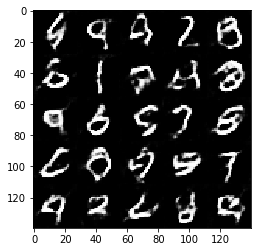

Epoch 1/2... Batch 28/32... Discriminator Loss: 1.2735... Generator Loss: 1.4603
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.2902... Generator Loss: 0.8363
Epoch 1/2... Batch 16/32... Discriminator Loss: 1.2935... Generator Loss: 1.1800
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.3878... Generator Loss: 0.9537
Epoch 1/2... Batch 4/32... Discriminator Loss: 1.2388... Generator Loss: 0.8154
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.3413... Generator Loss: 0.7592
Epoch 1/2... Batch 24/32... Discriminator Loss: 1.3030... Generator Loss: 0.8869
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.3352... Generator Loss: 0.7314
Epoch 1/2... Batch 12/32... Discriminator Loss: 1.2318... Generator Loss: 0.8616
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.3071... Generator Loss: 0.9598


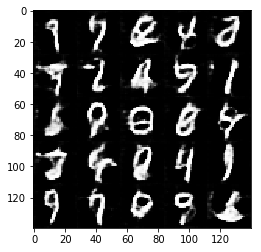

Epoch 1/2... Batch 0/32... Discriminator Loss: 1.4015... Generator Loss: 1.1655
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.2370... Generator Loss: 0.8722
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.2334... Generator Loss: 0.9571
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.1754... Generator Loss: 0.9629
Epoch 1/2... Batch 8/32... Discriminator Loss: 1.2758... Generator Loss: 0.9330
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.2111... Generator Loss: 0.9123
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.2268... Generator Loss: 0.8848
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.3380... Generator Loss: 0.6931
Epoch 1/2... Batch 16/32... Discriminator Loss: 1.3503... Generator Loss: 0.6737
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.1899... Generator Loss: 0.9495


Epoch 1/2... Batch 4/32... Discriminator Loss: 1.3502... Generator Loss: 0.7946
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.6173... Generator Loss: 0.3858
Epoch 1/2... Batch 24/32... Discriminator Loss: 1.1826... Generator Loss: 1.2047
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.1695... Generator Loss: 0.9997
Epoch 1/2... Batch 12/32... Discriminator Loss: 1.7822... Generator Loss: 0.3275
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.1935... Generator Loss: 0.9280
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.2795... Generator Loss: 0.8469
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.2993... Generator Loss: 0.7200
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.3835... Generator Loss: 0.5948
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.2737... Generator Loss: 1.1833


Epoch 1/2... Batch 8/32... Discriminator Loss: 1.2197... Generator Loss: 1.1131
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.2268... Generator Loss: 0.7469
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.1555... Generator Loss: 1.3168
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.1996... Generator Loss: 0.9884
Epoch 1/2... Batch 16/32... Discriminator Loss: 1.2056... Generator Loss: 0.9663
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.0906... Generator Loss: 1.0720
Epoch 1/2... Batch 4/32... Discriminator Loss: 1.2758... Generator Loss: 0.8712
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.2600... Generator Loss: 0.8021
Epoch 1/2... Batch 24/32... Discriminator Loss: 1.5076... Generator Loss: 0.4905
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.1513... Generator Loss: 1.0513


Epoch 1/2... Batch 12/32... Discriminator Loss: 1.2404... Generator Loss: 0.7462
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.2151... Generator Loss: 0.7457
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.1948... Generator Loss: 0.8099
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.4345... Generator Loss: 0.6799
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.2227... Generator Loss: 1.1295
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.2142... Generator Loss: 0.7964
Epoch 1/2... Batch 8/32... Discriminator Loss: 1.5467... Generator Loss: 0.4418
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.2419... Generator Loss: 0.8812
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.1929... Generator Loss: 0.9330
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.2918... Generator Loss: 0.6972


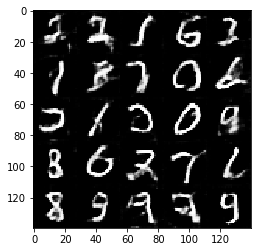

Epoch 1/2... Batch 16/32... Discriminator Loss: 1.2982... Generator Loss: 0.7113
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.1570... Generator Loss: 1.0393
Epoch 1/2... Batch 4/32... Discriminator Loss: 1.3004... Generator Loss: 0.6471
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.3420... Generator Loss: 0.6772
Epoch 1/2... Batch 24/32... Discriminator Loss: 1.1555... Generator Loss: 1.3537
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.3027... Generator Loss: 0.6806
Epoch 1/2... Batch 12/32... Discriminator Loss: 1.3563... Generator Loss: 0.5881
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.8155... Generator Loss: 2.3532
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.3183... Generator Loss: 0.7011
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.2315... Generator Loss: 0.9403


Epoch 1/2... Batch 20/32... Discriminator Loss: 1.1793... Generator Loss: 1.0284
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.0892... Generator Loss: 0.9362
Epoch 1/2... Batch 8/32... Discriminator Loss: 1.1085... Generator Loss: 1.0675
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.3466... Generator Loss: 0.5698
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.2312... Generator Loss: 0.7964
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.1495... Generator Loss: 0.8909
Epoch 1/2... Batch 16/32... Discriminator Loss: 1.1414... Generator Loss: 1.0439
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.2235... Generator Loss: 0.7847
Epoch 1/2... Batch 4/32... Discriminator Loss: 1.1263... Generator Loss: 0.8272
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.1855... Generator Loss: 0.9195


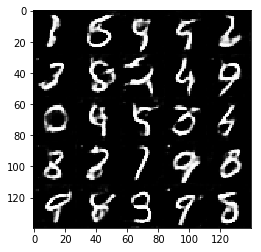

Epoch 1/2... Batch 24/32... Discriminator Loss: 1.1729... Generator Loss: 1.0136
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.1279... Generator Loss: 0.9182
Epoch 1/2... Batch 12/32... Discriminator Loss: 1.1989... Generator Loss: 0.9970
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.1371... Generator Loss: 0.9199
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.1082... Generator Loss: 1.5997
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.2155... Generator Loss: 0.8431
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.2408... Generator Loss: 0.7606
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.1109... Generator Loss: 0.9468
Epoch 1/2... Batch 8/32... Discriminator Loss: 1.1772... Generator Loss: 0.8483
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.2199... Generator Loss: 0.7754


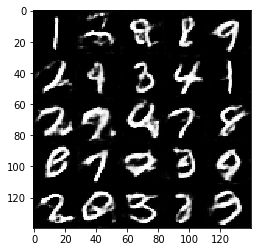

Epoch 1/2... Batch 28/32... Discriminator Loss: 1.1162... Generator Loss: 0.8748
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.0949... Generator Loss: 1.3559
Epoch 1/2... Batch 16/32... Discriminator Loss: 1.1668... Generator Loss: 1.3719
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.2834... Generator Loss: 0.8877
Epoch 1/2... Batch 4/32... Discriminator Loss: 1.2194... Generator Loss: 0.6292
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.2572... Generator Loss: 0.8150
Epoch 1/2... Batch 24/32... Discriminator Loss: 1.2014... Generator Loss: 0.9499
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.1651... Generator Loss: 1.0990
Epoch 1/2... Batch 12/32... Discriminator Loss: 1.1958... Generator Loss: 0.6468
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.2377... Generator Loss: 0.7284


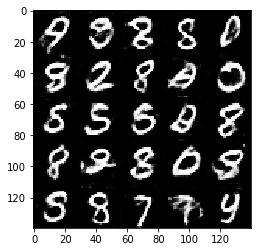

Epoch 1/2... Batch 0/32... Discriminator Loss: 1.0945... Generator Loss: 1.6616
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.0752... Generator Loss: 1.0521
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.1310... Generator Loss: 0.9083
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.1948... Generator Loss: 1.4380
Epoch 1/2... Batch 8/32... Discriminator Loss: 1.0658... Generator Loss: 1.1198
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.1183... Generator Loss: 0.8089
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.0765... Generator Loss: 1.2882
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.0931... Generator Loss: 0.8643
Epoch 1/2... Batch 16/32... Discriminator Loss: 1.6573... Generator Loss: 0.3879
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.0177... Generator Loss: 1.0184


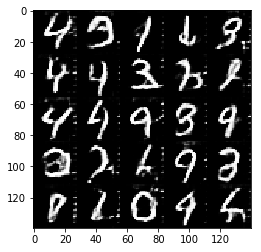

Epoch 1/2... Batch 4/32... Discriminator Loss: 1.0874... Generator Loss: 0.8322
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.0030... Generator Loss: 1.1890
Epoch 1/2... Batch 24/32... Discriminator Loss: 0.9410... Generator Loss: 1.2906
Epoch 1/2... Batch 2/32... Discriminator Loss: 1.6500... Generator Loss: 0.4755
Epoch 1/2... Batch 12/32... Discriminator Loss: 1.0398... Generator Loss: 1.3277
Epoch 1/2... Batch 22/32... Discriminator Loss: 1.0729... Generator Loss: 0.9325
Epoch 1/2... Batch 0/32... Discriminator Loss: 1.0282... Generator Loss: 1.1327
Epoch 1/2... Batch 10/32... Discriminator Loss: 1.1458... Generator Loss: 1.1666
Epoch 1/2... Batch 20/32... Discriminator Loss: 1.2103... Generator Loss: 0.7852
Epoch 1/2... Batch 30/32... Discriminator Loss: 1.0377... Generator Loss: 0.9666


Epoch 1/2... Batch 8/32... Discriminator Loss: 1.1421... Generator Loss: 0.7143
Epoch 1/2... Batch 18/32... Discriminator Loss: 1.0981... Generator Loss: 1.1391
Epoch 1/2... Batch 28/32... Discriminator Loss: 1.1605... Generator Loss: 0.9917
Epoch 1/2... Batch 6/32... Discriminator Loss: 1.0725... Generator Loss: 0.9570
Epoch 1/2... Batch 16/32... Discriminator Loss: 0.8915... Generator Loss: 1.3268
Epoch 1/2... Batch 26/32... Discriminator Loss: 1.0301... Generator Loss: 1.2180
Epoch 1/2... Batch 4/32... Discriminator Loss: 1.1040... Generator Loss: 1.3670
Epoch 1/2... Batch 14/32... Discriminator Loss: 1.0332... Generator Loss: 0.9940
Epoch 2/2... Batch 24/32... Discriminator Loss: 1.1102... Generator Loss: 1.1678
Epoch 2/2... Batch 2/32... Discriminator Loss: 1.4275... Generator Loss: 0.5469


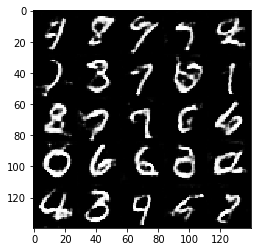

Epoch 2/2... Batch 12/32... Discriminator Loss: 1.0554... Generator Loss: 1.2392
Epoch 2/2... Batch 22/32... Discriminator Loss: 0.9852... Generator Loss: 1.0919
Epoch 2/2... Batch 0/32... Discriminator Loss: 0.9948... Generator Loss: 1.2040
Epoch 2/2... Batch 10/32... Discriminator Loss: 1.1941... Generator Loss: 0.9164
Epoch 2/2... Batch 20/32... Discriminator Loss: 1.1003... Generator Loss: 1.1680
Epoch 2/2... Batch 30/32... Discriminator Loss: 1.0815... Generator Loss: 1.0711
Epoch 2/2... Batch 8/32... Discriminator Loss: 1.0726... Generator Loss: 1.0904
Epoch 2/2... Batch 18/32... Discriminator Loss: 1.0082... Generator Loss: 1.3391
Epoch 2/2... Batch 28/32... Discriminator Loss: 0.9981... Generator Loss: 1.2448
Epoch 2/2... Batch 6/32... Discriminator Loss: 1.3014... Generator Loss: 0.7041


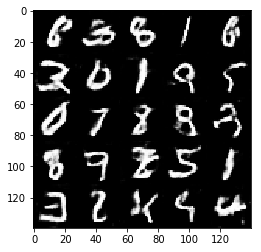

Epoch 2/2... Batch 16/32... Discriminator Loss: 0.9870... Generator Loss: 1.1223
Epoch 2/2... Batch 26/32... Discriminator Loss: 1.0874... Generator Loss: 0.8734
Epoch 2/2... Batch 4/32... Discriminator Loss: 0.9940... Generator Loss: 1.1797
Epoch 2/2... Batch 14/32... Discriminator Loss: 1.0517... Generator Loss: 1.0204
Epoch 2/2... Batch 24/32... Discriminator Loss: 0.9722... Generator Loss: 0.9922
Epoch 2/2... Batch 2/32... Discriminator Loss: 0.8641... Generator Loss: 1.2128
Epoch 2/2... Batch 12/32... Discriminator Loss: 0.9786... Generator Loss: 1.2637
Epoch 2/2... Batch 22/32... Discriminator Loss: 1.1788... Generator Loss: 0.8010
Epoch 2/2... Batch 0/32... Discriminator Loss: 1.0847... Generator Loss: 0.8550
Epoch 2/2... Batch 10/32... Discriminator Loss: 0.9470... Generator Loss: 1.1044


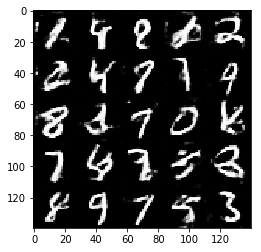

Epoch 2/2... Batch 20/32... Discriminator Loss: 0.9459... Generator Loss: 1.2624
Epoch 2/2... Batch 30/32... Discriminator Loss: 1.2695... Generator Loss: 2.3501
Epoch 2/2... Batch 8/32... Discriminator Loss: 0.9323... Generator Loss: 1.0804
Epoch 2/2... Batch 18/32... Discriminator Loss: 1.1154... Generator Loss: 0.8104
Epoch 2/2... Batch 28/32... Discriminator Loss: 1.1288... Generator Loss: 0.7583
Epoch 2/2... Batch 6/32... Discriminator Loss: 1.1072... Generator Loss: 0.9080
Epoch 2/2... Batch 16/32... Discriminator Loss: 1.2872... Generator Loss: 0.8473
Epoch 2/2... Batch 26/32... Discriminator Loss: 1.0744... Generator Loss: 0.9808
Epoch 2/2... Batch 4/32... Discriminator Loss: 0.9310... Generator Loss: 1.2835
Epoch 2/2... Batch 14/32... Discriminator Loss: 1.0323... Generator Loss: 1.2954


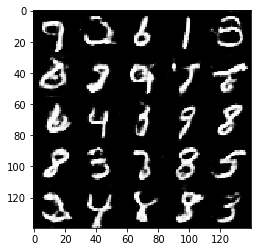

Epoch 2/2... Batch 24/32... Discriminator Loss: 1.2013... Generator Loss: 0.7018
Epoch 2/2... Batch 2/32... Discriminator Loss: 0.9638... Generator Loss: 1.2420
Epoch 2/2... Batch 12/32... Discriminator Loss: 0.8831... Generator Loss: 1.1325
Epoch 2/2... Batch 22/32... Discriminator Loss: 1.0212... Generator Loss: 1.1428
Epoch 2/2... Batch 0/32... Discriminator Loss: 0.8025... Generator Loss: 1.4102
Epoch 2/2... Batch 10/32... Discriminator Loss: 0.9403... Generator Loss: 1.7363
Epoch 2/2... Batch 20/32... Discriminator Loss: 0.9725... Generator Loss: 2.0372
Epoch 2/2... Batch 30/32... Discriminator Loss: 0.9953... Generator Loss: 1.5092
Epoch 2/2... Batch 8/32... Discriminator Loss: 0.9278... Generator Loss: 1.3193
Epoch 2/2... Batch 18/32... Discriminator Loss: 1.0201... Generator Loss: 1.0217


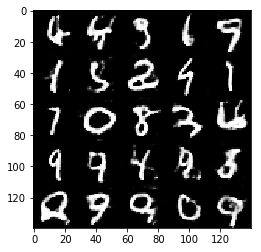

Epoch 2/2... Batch 28/32... Discriminator Loss: 1.1535... Generator Loss: 0.9426
Epoch 2/2... Batch 6/32... Discriminator Loss: 1.3587... Generator Loss: 0.6321
Epoch 2/2... Batch 16/32... Discriminator Loss: 1.4296... Generator Loss: 0.6389
Epoch 2/2... Batch 26/32... Discriminator Loss: 1.0976... Generator Loss: 0.8905
Epoch 2/2... Batch 4/32... Discriminator Loss: 0.9088... Generator Loss: 1.6692
Epoch 2/2... Batch 14/32... Discriminator Loss: 0.9897... Generator Loss: 1.0470
Epoch 2/2... Batch 24/32... Discriminator Loss: 1.2629... Generator Loss: 0.6185
Epoch 2/2... Batch 2/32... Discriminator Loss: 1.1558... Generator Loss: 0.7971
Epoch 2/2... Batch 12/32... Discriminator Loss: 0.8301... Generator Loss: 1.3868
Epoch 2/2... Batch 22/32... Discriminator Loss: 0.9239... Generator Loss: 1.5102


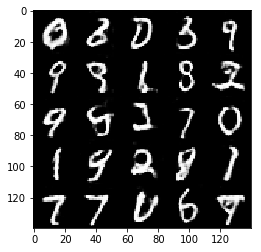

Epoch 2/2... Batch 0/32... Discriminator Loss: 1.0209... Generator Loss: 0.9847
Epoch 2/2... Batch 10/32... Discriminator Loss: 1.0987... Generator Loss: 0.8941
Epoch 2/2... Batch 20/32... Discriminator Loss: 0.8852... Generator Loss: 1.1284
Epoch 2/2... Batch 30/32... Discriminator Loss: 0.9610... Generator Loss: 1.0520
Epoch 2/2... Batch 8/32... Discriminator Loss: 0.9917... Generator Loss: 1.8898
Epoch 2/2... Batch 18/32... Discriminator Loss: 0.9510... Generator Loss: 1.2443
Epoch 2/2... Batch 28/32... Discriminator Loss: 0.9322... Generator Loss: 1.3683
Epoch 2/2... Batch 6/32... Discriminator Loss: 1.0276... Generator Loss: 1.0101
Epoch 2/2... Batch 16/32... Discriminator Loss: 1.0601... Generator Loss: 1.5840
Epoch 2/2... Batch 26/32... Discriminator Loss: 1.0890... Generator Loss: 0.8699


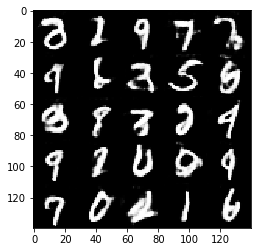

Epoch 2/2... Batch 4/32... Discriminator Loss: 1.0015... Generator Loss: 1.0156
Epoch 2/2... Batch 14/32... Discriminator Loss: 1.1933... Generator Loss: 0.7382
Epoch 2/2... Batch 24/32... Discriminator Loss: 1.0447... Generator Loss: 1.8510
Epoch 2/2... Batch 2/32... Discriminator Loss: 1.0578... Generator Loss: 0.8295
Epoch 2/2... Batch 12/32... Discriminator Loss: 0.9715... Generator Loss: 1.3523
Epoch 2/2... Batch 22/32... Discriminator Loss: 1.0152... Generator Loss: 0.8828
Epoch 2/2... Batch 0/32... Discriminator Loss: 0.9379... Generator Loss: 1.1096
Epoch 2/2... Batch 10/32... Discriminator Loss: 0.8966... Generator Loss: 1.2915
Epoch 2/2... Batch 20/32... Discriminator Loss: 0.8595... Generator Loss: 1.2306
Epoch 2/2... Batch 30/32... Discriminator Loss: 0.8082... Generator Loss: 1.5465


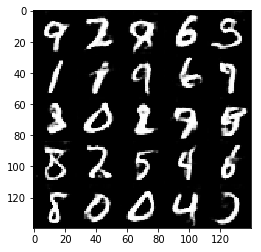

Epoch 2/2... Batch 8/32... Discriminator Loss: 0.9265... Generator Loss: 1.9364
Epoch 2/2... Batch 18/32... Discriminator Loss: 0.7831... Generator Loss: 1.4243
Epoch 2/2... Batch 28/32... Discriminator Loss: 1.3838... Generator Loss: 0.6572
Epoch 2/2... Batch 6/32... Discriminator Loss: 1.0216... Generator Loss: 1.2144
Epoch 2/2... Batch 16/32... Discriminator Loss: 1.6533... Generator Loss: 0.7365
Epoch 2/2... Batch 26/32... Discriminator Loss: 1.0078... Generator Loss: 1.0921
Epoch 2/2... Batch 4/32... Discriminator Loss: 0.9490... Generator Loss: 1.2674
Epoch 2/2... Batch 14/32... Discriminator Loss: 0.9854... Generator Loss: 0.9670
Epoch 2/2... Batch 24/32... Discriminator Loss: 1.1007... Generator Loss: 0.8359
Epoch 2/2... Batch 2/32... Discriminator Loss: 1.2034... Generator Loss: 0.6769


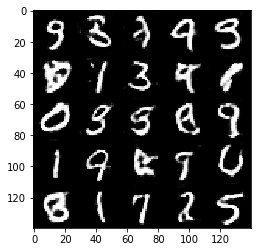

Epoch 2/2... Batch 12/32... Discriminator Loss: 0.9370... Generator Loss: 1.4107
Epoch 2/2... Batch 22/32... Discriminator Loss: 1.1932... Generator Loss: 0.7206
Epoch 2/2... Batch 0/32... Discriminator Loss: 0.9489... Generator Loss: 1.5292
Epoch 2/2... Batch 10/32... Discriminator Loss: 1.0100... Generator Loss: 1.1079
Epoch 2/2... Batch 20/32... Discriminator Loss: 1.0062... Generator Loss: 1.2496
Epoch 2/2... Batch 30/32... Discriminator Loss: 0.8568... Generator Loss: 1.4144
Epoch 2/2... Batch 8/32... Discriminator Loss: 0.8524... Generator Loss: 2.1593
Epoch 2/2... Batch 18/32... Discriminator Loss: 1.0915... Generator Loss: 0.8661
Epoch 2/2... Batch 28/32... Discriminator Loss: 0.8091... Generator Loss: 1.5033
Epoch 2/2... Batch 6/32... Discriminator Loss: 0.7397... Generator Loss: 1.4864


Epoch 2/2... Batch 16/32... Discriminator Loss: 0.8488... Generator Loss: 1.3341
Epoch 2/2... Batch 26/32... Discriminator Loss: 0.9471... Generator Loss: 1.0502
Epoch 2/2... Batch 4/32... Discriminator Loss: 0.8161... Generator Loss: 2.0973
Epoch 2/2... Batch 14/32... Discriminator Loss: 1.0638... Generator Loss: 0.8585
Epoch 2/2... Batch 24/32... Discriminator Loss: 0.8661... Generator Loss: 1.3131
Epoch 2/2... Batch 2/32... Discriminator Loss: 0.9287... Generator Loss: 1.3145
Epoch 2/2... Batch 12/32... Discriminator Loss: 0.9726... Generator Loss: 1.1449
Epoch 2/2... Batch 22/32... Discriminator Loss: 0.7962... Generator Loss: 1.4571
Epoch 2/2... Batch 0/32... Discriminator Loss: 0.7880... Generator Loss: 1.4542
Epoch 2/2... Batch 10/32... Discriminator Loss: 1.0680... Generator Loss: 0.9423


Epoch 2/2... Batch 20/32... Discriminator Loss: 1.0237... Generator Loss: 0.9697
Epoch 2/2... Batch 30/32... Discriminator Loss: 1.0300... Generator Loss: 1.0062
Epoch 2/2... Batch 8/32... Discriminator Loss: 1.0122... Generator Loss: 1.0278
Epoch 2/2... Batch 18/32... Discriminator Loss: 0.7558... Generator Loss: 1.8026
Epoch 2/2... Batch 28/32... Discriminator Loss: 1.3472... Generator Loss: 0.5786
Epoch 2/2... Batch 6/32... Discriminator Loss: 0.8658... Generator Loss: 1.2175
Epoch 2/2... Batch 16/32... Discriminator Loss: 1.1253... Generator Loss: 1.6355
Epoch 2/2... Batch 26/32... Discriminator Loss: 0.9928... Generator Loss: 1.0098
Epoch 2/2... Batch 4/32... Discriminator Loss: 0.8170... Generator Loss: 1.5350
Epoch 2/2... Batch 14/32... Discriminator Loss: 0.9435... Generator Loss: 1.7428


Epoch 2/2... Batch 24/32... Discriminator Loss: 0.7794... Generator Loss: 1.8193
Epoch 2/2... Batch 2/32... Discriminator Loss: 0.8528... Generator Loss: 1.4941
Epoch 2/2... Batch 12/32... Discriminator Loss: 0.8491... Generator Loss: 1.3307
Epoch 2/2... Batch 22/32... Discriminator Loss: 0.9698... Generator Loss: 1.6979
Epoch 2/2... Batch 0/32... Discriminator Loss: 0.9224... Generator Loss: 2.1718
Epoch 2/2... Batch 10/32... Discriminator Loss: 0.9228... Generator Loss: 1.2898
Epoch 2/2... Batch 20/32... Discriminator Loss: 0.7434... Generator Loss: 1.5113
Epoch 2/2... Batch 30/32... Discriminator Loss: 1.0783... Generator Loss: 0.9888
Epoch 2/2... Batch 8/32... Discriminator Loss: 0.9271... Generator Loss: 1.1328
Epoch 2/2... Batch 18/32... Discriminator Loss: 0.9201... Generator Loss: 1.3256


Epoch 2/2... Batch 28/32... Discriminator Loss: 0.7161... Generator Loss: 1.9346
Epoch 2/2... Batch 6/32... Discriminator Loss: 0.8113... Generator Loss: 1.6124
Epoch 2/2... Batch 16/32... Discriminator Loss: 0.8270... Generator Loss: 1.7721
Epoch 2/2... Batch 26/32... Discriminator Loss: 0.9613... Generator Loss: 0.9562
Epoch 2/2... Batch 4/32... Discriminator Loss: 1.0829... Generator Loss: 0.8948
Epoch 2/2... Batch 14/32... Discriminator Loss: 1.1009... Generator Loss: 0.8362
Epoch 2/2... Batch 24/32... Discriminator Loss: 1.0747... Generator Loss: 0.8795
Epoch 2/2... Batch 2/32... Discriminator Loss: 0.8980... Generator Loss: 1.2246
Epoch 2/2... Batch 12/32... Discriminator Loss: 0.8015... Generator Loss: 1.5325
Epoch 2/2... Batch 22/32... Discriminator Loss: 1.2017... Generator Loss: 0.8608


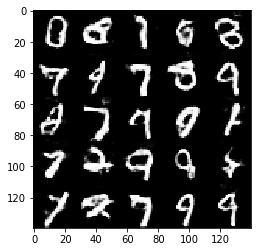

Epoch 2/2... Batch 0/32... Discriminator Loss: 2.0690... Generator Loss: 3.3903
Epoch 2/2... Batch 10/32... Discriminator Loss: 1.0569... Generator Loss: 1.1655
Epoch 2/2... Batch 20/32... Discriminator Loss: 0.9980... Generator Loss: 1.3248
Epoch 2/2... Batch 30/32... Discriminator Loss: 0.8653... Generator Loss: 1.5391
Epoch 2/2... Batch 8/32... Discriminator Loss: 0.8570... Generator Loss: 1.5731
Epoch 2/2... Batch 18/32... Discriminator Loss: 0.8462... Generator Loss: 1.2605
Epoch 2/2... Batch 28/32... Discriminator Loss: 0.8734... Generator Loss: 1.2767
Epoch 2/2... Batch 6/32... Discriminator Loss: 0.9142... Generator Loss: 1.2177
Epoch 2/2... Batch 16/32... Discriminator Loss: 0.8974... Generator Loss: 1.2187
Epoch 2/2... Batch 26/32... Discriminator Loss: 0.9855... Generator Loss: 1.3702


Epoch 2/2... Batch 4/32... Discriminator Loss: 0.9088... Generator Loss: 1.4161
Epoch 2/2... Batch 14/32... Discriminator Loss: 0.8403... Generator Loss: 1.1910
Epoch 2/2... Batch 24/32... Discriminator Loss: 0.8523... Generator Loss: 1.8134
Epoch 2/2... Batch 2/32... Discriminator Loss: 0.9648... Generator Loss: 1.0086
Epoch 2/2... Batch 12/32... Discriminator Loss: 0.8371... Generator Loss: 1.4540
Epoch 2/2... Batch 22/32... Discriminator Loss: 1.1460... Generator Loss: 0.7652
Epoch 2/2... Batch 0/32... Discriminator Loss: 0.9755... Generator Loss: 0.8278
Epoch 2/2... Batch 10/32... Discriminator Loss: 0.9152... Generator Loss: 1.3181
Epoch 2/2... Batch 20/32... Discriminator Loss: 0.8045... Generator Loss: 1.6396
Epoch 2/2... Batch 30/32... Discriminator Loss: 0.7611... Generator Loss: 1.4761


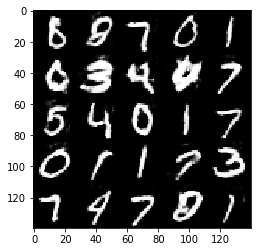

Epoch 2/2... Batch 8/32... Discriminator Loss: 0.7573... Generator Loss: 1.8836
Epoch 2/2... Batch 18/32... Discriminator Loss: 0.8392... Generator Loss: 1.5379
Epoch 2/2... Batch 28/32... Discriminator Loss: 0.9149... Generator Loss: 0.9469
Epoch 2/2... Batch 6/32... Discriminator Loss: 0.8755... Generator Loss: 1.5576
Epoch 2/2... Batch 16/32... Discriminator Loss: 0.8424... Generator Loss: 1.4147
Epoch 2/2... Batch 26/32... Discriminator Loss: 0.8371... Generator Loss: 1.3780
Epoch 2/2... Batch 4/32... Discriminator Loss: 0.9501... Generator Loss: 1.2085
Epoch 2/2... Batch 14/32... Discriminator Loss: 0.6466... Generator Loss: 1.8390
Epoch 2/2... Batch 24/32... Discriminator Loss: 0.8059... Generator Loss: 1.3147
Epoch 2/2... Batch 2/32... Discriminator Loss: 1.3675... Generator Loss: 0.7884


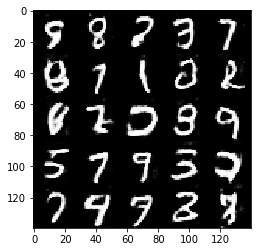

Epoch 2/2... Batch 12/32... Discriminator Loss: 0.8189... Generator Loss: 1.4505
Epoch 2/2... Batch 22/32... Discriminator Loss: 0.8201... Generator Loss: 1.6737
Epoch 2/2... Batch 0/32... Discriminator Loss: 0.7529... Generator Loss: 1.5670
Epoch 2/2... Batch 10/32... Discriminator Loss: 0.9377... Generator Loss: 0.9787
Epoch 2/2... Batch 20/32... Discriminator Loss: 0.9085... Generator Loss: 1.1256
Epoch 2/2... Batch 30/32... Discriminator Loss: 0.6951... Generator Loss: 2.1757
Epoch 2/2... Batch 8/32... Discriminator Loss: 0.7581... Generator Loss: 1.6762
Epoch 2/2... Batch 18/32... Discriminator Loss: 2.6662... Generator Loss: 0.2331
Epoch 2/2... Batch 28/32... Discriminator Loss: 0.6019... Generator Loss: 1.8414
Epoch 2/2... Batch 6/32... Discriminator Loss: 1.4057... Generator Loss: 3.3107


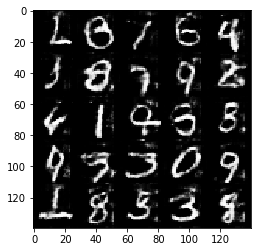

Epoch 2/2... Batch 16/32... Discriminator Loss: 2.5625... Generator Loss: 0.2204
Epoch 2/2... Batch 26/32... Discriminator Loss: 1.0282... Generator Loss: 1.4716
Epoch 2/2... Batch 4/32... Discriminator Loss: 0.9772... Generator Loss: 1.1888
Epoch 2/2... Batch 14/32... Discriminator Loss: 0.8847... Generator Loss: 1.2952
Epoch 2/2... Batch 24/32... Discriminator Loss: 0.9265... Generator Loss: 1.2879
Epoch 2/2... Batch 2/32... Discriminator Loss: 0.8359... Generator Loss: 1.5086
Epoch 2/2... Batch 12/32... Discriminator Loss: 0.9794... Generator Loss: 1.1474
Epoch 2/2... Batch 22/32... Discriminator Loss: 0.9258... Generator Loss: 1.4021
Epoch 2/2... Batch 0/32... Discriminator Loss: 1.0241... Generator Loss: 1.3106
Epoch 2/2... Batch 10/32... Discriminator Loss: 0.9206... Generator Loss: 1.4447


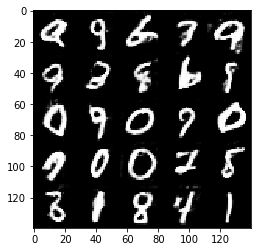

Epoch 2/2... Batch 20/32... Discriminator Loss: 0.9949... Generator Loss: 1.8885
Epoch 2/2... Batch 30/32... Discriminator Loss: 1.0386... Generator Loss: 1.0730
Epoch 2/2... Batch 8/32... Discriminator Loss: 0.9839... Generator Loss: 1.2583
Epoch 2/2... Batch 18/32... Discriminator Loss: 1.0173... Generator Loss: 1.0860
Epoch 2/2... Batch 28/32... Discriminator Loss: 0.9630... Generator Loss: 1.1623


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA. It will take around 20 minutes on the average GPU to run one epoch. You can run the whole epoch or stop when it starts to generate realistic faces.

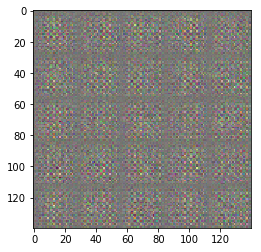

Epoch 1/1... Batch 0/32... Discriminator Loss: 1.2849... Generator Loss: 0.6796
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2033... Generator Loss: 0.8650
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.1109... Generator Loss: 1.4090
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.1733... Generator Loss: 0.9092
Epoch 1/1... Batch 8/32... Discriminator Loss: 0.9267... Generator Loss: 1.6691
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.1714... Generator Loss: 0.9264
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.5210... Generator Loss: 1.8871
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.2998... Generator Loss: 0.9048
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.8347... Generator Loss: 0.4172
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.0765... Generator Loss: 1.0473


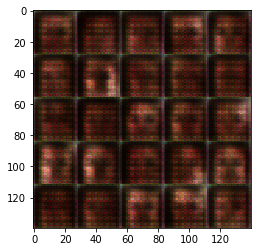

Epoch 1/1... Batch 4/32... Discriminator Loss: 1.2001... Generator Loss: 0.8977
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.1658... Generator Loss: 0.9530
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.0593... Generator Loss: 1.0752
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.4486... Generator Loss: 0.5584
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2995... Generator Loss: 0.7818
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.1267... Generator Loss: 0.9866
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.1972... Generator Loss: 0.9416
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2441... Generator Loss: 0.7993
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.3097... Generator Loss: 0.9153
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.1892... Generator Loss: 1.0209


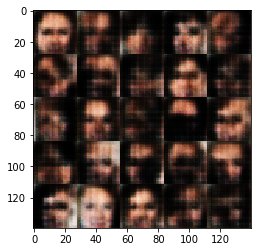

Epoch 1/1... Batch 8/32... Discriminator Loss: 1.3166... Generator Loss: 0.8454
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2232... Generator Loss: 0.7732
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.3408... Generator Loss: 0.7966
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.3055... Generator Loss: 0.7930
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.3529... Generator Loss: 0.6236
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.3101... Generator Loss: 1.5472
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.1985... Generator Loss: 0.8762
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.1885... Generator Loss: 0.9750
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.3752... Generator Loss: 0.7565
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.2881... Generator Loss: 0.9316


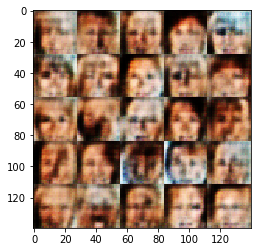

Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2099... Generator Loss: 1.0180
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.3825... Generator Loss: 0.8066
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.2288... Generator Loss: 0.7105
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2322... Generator Loss: 0.8485
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.3441... Generator Loss: 0.9613
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2329... Generator Loss: 0.8110
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2526... Generator Loss: 0.9227
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.3362... Generator Loss: 0.8084
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.2903... Generator Loss: 0.6931
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.4127... Generator Loss: 0.6498


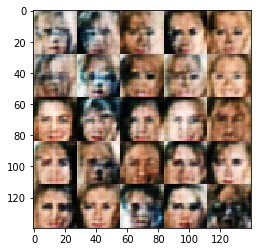

Epoch 1/1... Batch 16/32... Discriminator Loss: 1.2570... Generator Loss: 0.7806
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2371... Generator Loss: 0.8457
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.2924... Generator Loss: 1.0055
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.3064... Generator Loss: 1.0087
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.3827... Generator Loss: 0.6379
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.3982... Generator Loss: 0.5942
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.3272... Generator Loss: 0.7635
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.3338... Generator Loss: 0.7791
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.3750... Generator Loss: 1.0559
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2613... Generator Loss: 0.8606


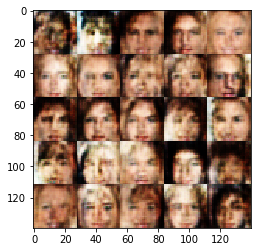

Epoch 1/1... Batch 20/32... Discriminator Loss: 1.2864... Generator Loss: 0.8232
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2672... Generator Loss: 0.8529
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2901... Generator Loss: 0.8418
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.3040... Generator Loss: 0.8994
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.3187... Generator Loss: 0.8863
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.3330... Generator Loss: 0.7312
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.3216... Generator Loss: 0.6891
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.4432... Generator Loss: 0.7417
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.3072... Generator Loss: 0.8009
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.3972... Generator Loss: 0.6201


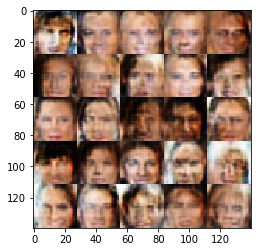

Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2641... Generator Loss: 0.8135
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.2999... Generator Loss: 0.8273
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.3158... Generator Loss: 0.8850
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.3095... Generator Loss: 0.8186
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.3065... Generator Loss: 0.8879
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.3236... Generator Loss: 0.6649
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.4318... Generator Loss: 0.9911
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2564... Generator Loss: 1.0236
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.4605... Generator Loss: 0.7153
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.3412... Generator Loss: 0.7878


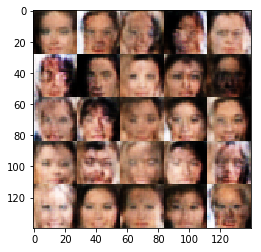

Epoch 1/1... Batch 28/32... Discriminator Loss: 1.3594... Generator Loss: 0.8424
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.2487... Generator Loss: 0.8956
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.3192... Generator Loss: 0.7852
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.4810... Generator Loss: 0.5123
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.3885... Generator Loss: 0.6834
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.3132... Generator Loss: 0.7198
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2561... Generator Loss: 0.7922
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.3828... Generator Loss: 0.7305
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.5420... Generator Loss: 1.4113
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.2988... Generator Loss: 0.8011


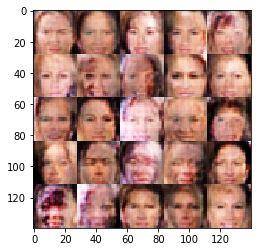

Epoch 1/1... Batch 0/32... Discriminator Loss: 1.4202... Generator Loss: 0.7262
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.3652... Generator Loss: 0.7763
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.3293... Generator Loss: 0.7999
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.3281... Generator Loss: 0.8251
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.3087... Generator Loss: 0.7789
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2829... Generator Loss: 0.7563
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.3519... Generator Loss: 0.8373
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.3357... Generator Loss: 0.8302
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.3931... Generator Loss: 0.9148
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.3867... Generator Loss: 0.9919


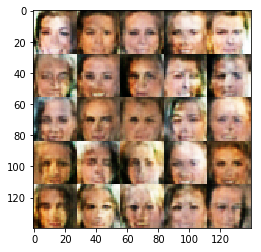

Epoch 1/1... Batch 4/32... Discriminator Loss: 1.3046... Generator Loss: 0.7817
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2947... Generator Loss: 0.8526
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.3667... Generator Loss: 0.7432
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.3631... Generator Loss: 0.7864
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.3797... Generator Loss: 0.8642
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.3726... Generator Loss: 0.6928
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.3196... Generator Loss: 0.7139
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2430... Generator Loss: 0.9057
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.3833... Generator Loss: 0.7472
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.4269... Generator Loss: 0.6905


Epoch 1/1... Batch 8/32... Discriminator Loss: 1.3620... Generator Loss: 0.8685
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.4221... Generator Loss: 1.0233
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.4310... Generator Loss: 0.8416
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.3260... Generator Loss: 0.8634
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.3608... Generator Loss: 0.6608
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.3731... Generator Loss: 0.6621
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.4282... Generator Loss: 0.7546
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.3456... Generator Loss: 0.7840
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.3152... Generator Loss: 0.7727
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.4408... Generator Loss: 1.0733


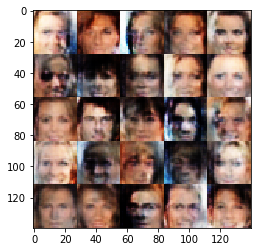

Epoch 1/1... Batch 12/32... Discriminator Loss: 1.3927... Generator Loss: 0.7113
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.3031... Generator Loss: 0.7318
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.3903... Generator Loss: 0.7833
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2651... Generator Loss: 0.8300
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.2904... Generator Loss: 0.7514
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.3741... Generator Loss: 0.9463
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.3798... Generator Loss: 0.8027
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.3641... Generator Loss: 0.8177
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.3519... Generator Loss: 0.6700
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.3609... Generator Loss: 0.6203


Epoch 1/1... Batch 16/32... Discriminator Loss: 1.2745... Generator Loss: 0.7904
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.3314... Generator Loss: 0.9050
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.3139... Generator Loss: 0.8567
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.3001... Generator Loss: 0.7567
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.4014... Generator Loss: 0.6491
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.3305... Generator Loss: 0.8301
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2449... Generator Loss: 0.8054
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.3128... Generator Loss: 0.8015
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.2412... Generator Loss: 0.9052
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.3801... Generator Loss: 0.6916


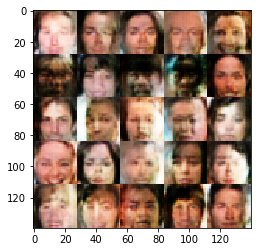

Epoch 1/1... Batch 20/32... Discriminator Loss: 1.3389... Generator Loss: 0.8686
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2862... Generator Loss: 0.8716
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.3488... Generator Loss: 0.6875
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.3758... Generator Loss: 0.7155
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.3173... Generator Loss: 0.8035
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.2592... Generator Loss: 0.8086
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.3311... Generator Loss: 0.7962
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2928... Generator Loss: 0.6980
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.4186... Generator Loss: 0.6124
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.4040... Generator Loss: 0.6386


Epoch 1/1... Batch 24/32... Discriminator Loss: 1.3140... Generator Loss: 0.7857
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.3192... Generator Loss: 1.0537
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.3075... Generator Loss: 0.6843
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.2743... Generator Loss: 0.9390
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.3063... Generator Loss: 0.8534
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.3167... Generator Loss: 0.8260
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.3515... Generator Loss: 0.7241
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.3064... Generator Loss: 0.7464
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.3286... Generator Loss: 0.7884
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2949... Generator Loss: 0.8430


Epoch 1/1... Batch 28/32... Discriminator Loss: 1.3236... Generator Loss: 0.8183
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.3404... Generator Loss: 0.7722
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.2894... Generator Loss: 0.8267
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.3895... Generator Loss: 0.7003
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.4835... Generator Loss: 0.5475
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2807... Generator Loss: 0.8379
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.3245... Generator Loss: 0.7912
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.3228... Generator Loss: 0.7869
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.3769... Generator Loss: 0.6696
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.3359... Generator Loss: 0.8160


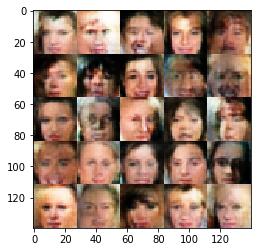

Epoch 1/1... Batch 0/32... Discriminator Loss: 1.2913... Generator Loss: 0.8542
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.3709... Generator Loss: 1.1245
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.2704... Generator Loss: 0.8856
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.3781... Generator Loss: 0.6827
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2927... Generator Loss: 0.8735
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2910... Generator Loss: 0.8039
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.3324... Generator Loss: 0.6958
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.2678... Generator Loss: 1.0261
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.3217... Generator Loss: 0.7660
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.3998... Generator Loss: 0.5870


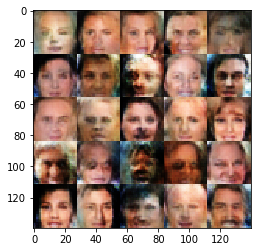

Epoch 1/1... Batch 4/32... Discriminator Loss: 1.4064... Generator Loss: 0.6600
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.4594... Generator Loss: 0.5677
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.3535... Generator Loss: 0.7332
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.4121... Generator Loss: 0.7802
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.3031... Generator Loss: 0.7136
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.2691... Generator Loss: 0.7726
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.2944... Generator Loss: 0.7886
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.3465... Generator Loss: 0.6201
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.3721... Generator Loss: 0.8908
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2831... Generator Loss: 1.0358


Epoch 1/1... Batch 8/32... Discriminator Loss: 1.4485... Generator Loss: 0.6511
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.4086... Generator Loss: 0.9624
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.3066... Generator Loss: 0.7683
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.3796... Generator Loss: 0.9134
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.4114... Generator Loss: 0.6145
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.3219... Generator Loss: 0.8682
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.5763... Generator Loss: 0.4176
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2707... Generator Loss: 0.9652
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2470... Generator Loss: 0.8123
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.3068... Generator Loss: 0.8163


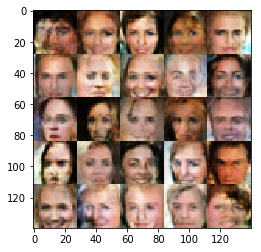

Epoch 1/1... Batch 12/32... Discriminator Loss: 1.3442... Generator Loss: 0.6770
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.1728... Generator Loss: 0.9667
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.2332... Generator Loss: 0.8703
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.4416... Generator Loss: 1.2607
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.3302... Generator Loss: 0.7517
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2266... Generator Loss: 0.7860
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2829... Generator Loss: 0.8555
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.3345... Generator Loss: 0.6906
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.5663... Generator Loss: 0.5030
Epoch 1/1... Batch 6/32... Discriminator Loss: 2.3569... Generator Loss: 0.1500


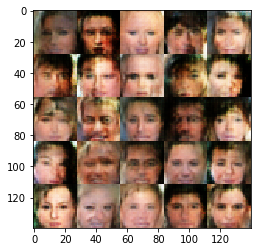

Epoch 1/1... Batch 16/32... Discriminator Loss: 1.3815... Generator Loss: 0.7613
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.3135... Generator Loss: 0.7988
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.3210... Generator Loss: 0.7269
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.1905... Generator Loss: 0.9726
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2583... Generator Loss: 0.7561
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.3266... Generator Loss: 0.7424
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.3413... Generator Loss: 0.8232
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.2620... Generator Loss: 0.8462
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.2772... Generator Loss: 0.8235
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.3554... Generator Loss: 0.8569


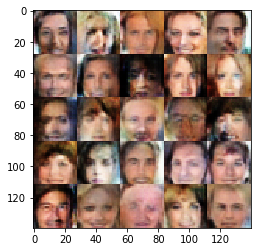

Epoch 1/1... Batch 20/32... Discriminator Loss: 1.3347... Generator Loss: 0.7490
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2496... Generator Loss: 0.8833
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.3812... Generator Loss: 0.6742
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.3044... Generator Loss: 0.7852
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.4162... Generator Loss: 1.1212
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.2807... Generator Loss: 0.8423
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.3436... Generator Loss: 0.8556
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2694... Generator Loss: 0.9849
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.2786... Generator Loss: 0.8893
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.3616... Generator Loss: 0.7344


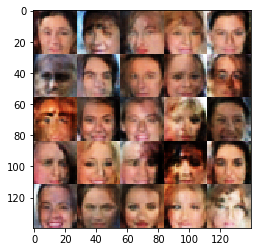

Epoch 1/1... Batch 24/32... Discriminator Loss: 1.3554... Generator Loss: 0.6126
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.2595... Generator Loss: 0.8331
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2876... Generator Loss: 0.7390
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.3046... Generator Loss: 0.7660
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.2860... Generator Loss: 0.9187
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.3176... Generator Loss: 0.9289
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.3477... Generator Loss: 0.9806
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.3757... Generator Loss: 0.6582
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2217... Generator Loss: 0.7896
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2788... Generator Loss: 0.7389


Epoch 1/1... Batch 28/32... Discriminator Loss: 1.3269... Generator Loss: 0.7745
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.3034... Generator Loss: 0.7038
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.2938... Generator Loss: 0.6771
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2914... Generator Loss: 0.7532
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.2541... Generator Loss: 0.7923
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.4664... Generator Loss: 0.5192
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.4551... Generator Loss: 0.5181
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.5102... Generator Loss: 0.4429
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2857... Generator Loss: 0.6769
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.3284... Generator Loss: 0.9855


Epoch 1/1... Batch 0/32... Discriminator Loss: 1.4694... Generator Loss: 0.5315
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2336... Generator Loss: 0.8267
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.2451... Generator Loss: 0.8210
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.4599... Generator Loss: 0.7328
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.3228... Generator Loss: 0.7343
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.3421... Generator Loss: 0.6865
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.2916... Generator Loss: 0.8018
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.3084... Generator Loss: 0.8928
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.2213... Generator Loss: 0.9102
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2841... Generator Loss: 0.7529


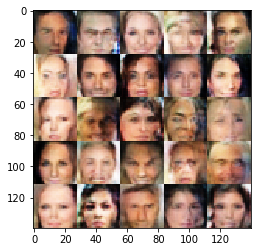

Epoch 1/1... Batch 4/32... Discriminator Loss: 1.3810... Generator Loss: 0.5641
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2641... Generator Loss: 0.9774
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.3676... Generator Loss: 0.9492
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.2543... Generator Loss: 0.7491
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2565... Generator Loss: 0.8012
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.2752... Generator Loss: 0.7893
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.1973... Generator Loss: 1.1553
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.4222... Generator Loss: 0.5364
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.3152... Generator Loss: 0.9309
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.3131... Generator Loss: 0.7875


Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2938... Generator Loss: 0.7363
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2117... Generator Loss: 0.6934
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.3704... Generator Loss: 0.6818
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.5337... Generator Loss: 0.4977
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.3521... Generator Loss: 0.7910
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.3803... Generator Loss: 0.6753
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.2981... Generator Loss: 0.6862
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2984... Generator Loss: 0.6614
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2796... Generator Loss: 1.1030
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.3059... Generator Loss: 0.8418


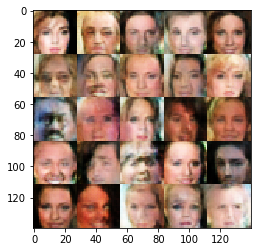

Epoch 1/1... Batch 12/32... Discriminator Loss: 1.1795... Generator Loss: 1.0505
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.4152... Generator Loss: 0.5585
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.3777... Generator Loss: 0.6582
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2611... Generator Loss: 1.0933
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.2864... Generator Loss: 0.8777
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.3721... Generator Loss: 0.5587
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2695... Generator Loss: 0.8145
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2445... Generator Loss: 0.8805
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.3617... Generator Loss: 0.7194
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.2781... Generator Loss: 1.0677


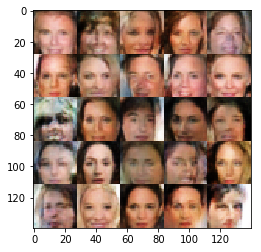

Epoch 1/1... Batch 16/32... Discriminator Loss: 1.2804... Generator Loss: 0.6529
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2843... Generator Loss: 0.7723
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.3711... Generator Loss: 1.0775
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2006... Generator Loss: 0.8208
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.4065... Generator Loss: 0.5746
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.2279... Generator Loss: 0.8058
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2192... Generator Loss: 0.9523
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.3210... Generator Loss: 0.9918
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.3965... Generator Loss: 0.4919
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.3686... Generator Loss: 0.5855


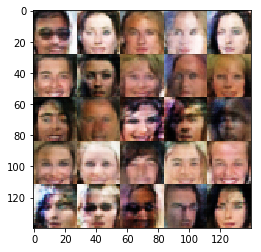

Epoch 1/1... Batch 20/32... Discriminator Loss: 1.3225... Generator Loss: 0.7625
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2873... Generator Loss: 0.9668
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.1870... Generator Loss: 0.9304
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2012... Generator Loss: 0.8137
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.2935... Generator Loss: 0.7405
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.3171... Generator Loss: 0.6475
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.3687... Generator Loss: 0.6788
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2838... Generator Loss: 0.7517
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.3729... Generator Loss: 0.5316
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2575... Generator Loss: 0.7500


Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2619... Generator Loss: 0.7805
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.2459... Generator Loss: 0.8865
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2163... Generator Loss: 0.9759
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.3875... Generator Loss: 0.5962
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.2207... Generator Loss: 0.9912
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.3005... Generator Loss: 0.8177
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.2893... Generator Loss: 0.7134
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.1807... Generator Loss: 0.8805
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.4547... Generator Loss: 0.5037
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2806... Generator Loss: 0.7589


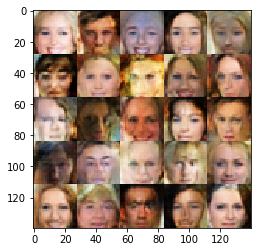

Epoch 1/1... Batch 28/32... Discriminator Loss: 1.2662... Generator Loss: 0.7606
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.2815... Generator Loss: 0.7125
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.2388... Generator Loss: 0.8505
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.7727... Generator Loss: 1.3539
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.2516... Generator Loss: 0.8130
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2117... Generator Loss: 0.9137
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2496... Generator Loss: 0.7407
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.2927... Generator Loss: 0.8316
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2644... Generator Loss: 0.7856
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.2464... Generator Loss: 1.0409


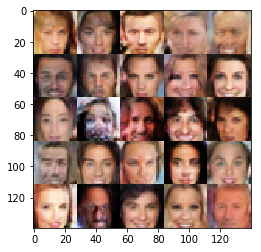

Epoch 1/1... Batch 0/32... Discriminator Loss: 1.2123... Generator Loss: 1.2526
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2541... Generator Loss: 0.8811
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.4473... Generator Loss: 0.4583
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.4079... Generator Loss: 0.7536
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2858... Generator Loss: 0.6822
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.3292... Generator Loss: 0.8510
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.3206... Generator Loss: 0.7318
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.2384... Generator Loss: 0.7556
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.2261... Generator Loss: 0.8546
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2222... Generator Loss: 0.9322


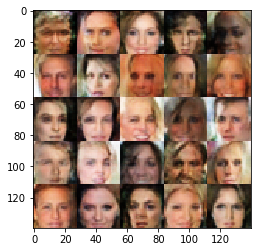

Epoch 1/1... Batch 4/32... Discriminator Loss: 1.3326... Generator Loss: 0.5956
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2443... Generator Loss: 0.7971
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.6102... Generator Loss: 0.4475
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.3413... Generator Loss: 0.8314
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2435... Generator Loss: 0.7967
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.2210... Generator Loss: 0.7845
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.1961... Generator Loss: 0.7883
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2758... Generator Loss: 0.9007
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.1957... Generator Loss: 0.8028
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2549... Generator Loss: 0.8308


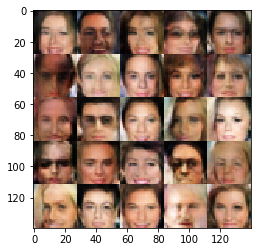

Epoch 1/1... Batch 8/32... Discriminator Loss: 1.1554... Generator Loss: 0.9656
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.6304... Generator Loss: 0.3630
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.2938... Generator Loss: 0.6782
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.3219... Generator Loss: 0.6909
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.3184... Generator Loss: 0.7304
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2511... Generator Loss: 0.7569
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.2538... Generator Loss: 0.9261
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2532... Generator Loss: 0.7982
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2427... Generator Loss: 0.7917
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.2463... Generator Loss: 0.7551


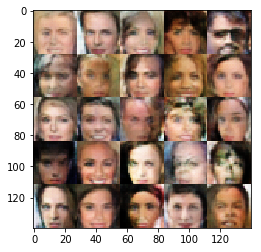

Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2184... Generator Loss: 0.8466
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.3474... Generator Loss: 0.5487
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.1932... Generator Loss: 0.8387
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2893... Generator Loss: 0.7428
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.2789... Generator Loss: 0.7942
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2859... Generator Loss: 0.8710
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2574... Generator Loss: 0.7053
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.3003... Generator Loss: 0.6453
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.2003... Generator Loss: 0.7775
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.3102... Generator Loss: 0.7801


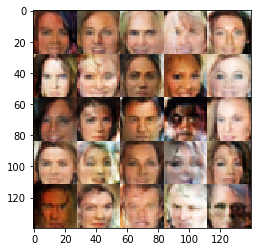

Epoch 1/1... Batch 16/32... Discriminator Loss: 1.2290... Generator Loss: 0.7847
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.3732... Generator Loss: 0.6494
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.1707... Generator Loss: 1.0910
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.3315... Generator Loss: 0.6962
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2630... Generator Loss: 0.9496
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.4182... Generator Loss: 0.5544
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2256... Generator Loss: 0.7261
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.2383... Generator Loss: 0.8266
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.3100... Generator Loss: 0.6550
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.4984... Generator Loss: 0.4802


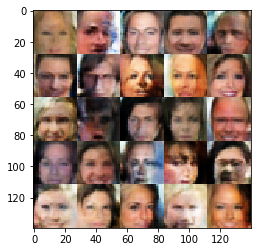

Epoch 1/1... Batch 20/32... Discriminator Loss: 1.2438... Generator Loss: 0.7716
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.3215... Generator Loss: 0.7668
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.3060... Generator Loss: 0.7061
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.4040... Generator Loss: 0.4977
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.2726... Generator Loss: 0.8258
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.2108... Generator Loss: 1.0518
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.2945... Generator Loss: 0.6659
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.3212... Generator Loss: 0.7536
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.4313... Generator Loss: 0.5420
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2580... Generator Loss: 0.8009


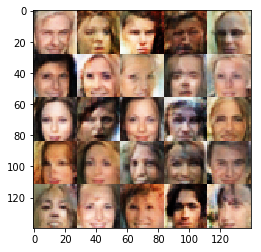

Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2401... Generator Loss: 0.9716
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.1501... Generator Loss: 1.0837
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2025... Generator Loss: 0.9308
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.4448... Generator Loss: 0.5007
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.1692... Generator Loss: 0.7470
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2832... Generator Loss: 0.6687
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.2397... Generator Loss: 0.7897
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.3022... Generator Loss: 0.8180
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2514... Generator Loss: 0.8515
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2272... Generator Loss: 0.8101


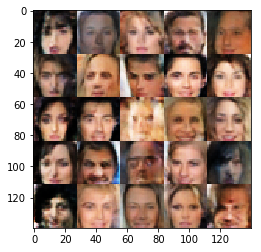

Epoch 1/1... Batch 28/32... Discriminator Loss: 1.2326... Generator Loss: 0.9158
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.3008... Generator Loss: 0.7380
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.3739... Generator Loss: 0.6117
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2148... Generator Loss: 0.9975
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.2729... Generator Loss: 0.7198
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2280... Generator Loss: 0.7219
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2737... Generator Loss: 0.6520
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.1731... Generator Loss: 0.9402
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.1593... Generator Loss: 0.9533
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.2637... Generator Loss: 0.8735


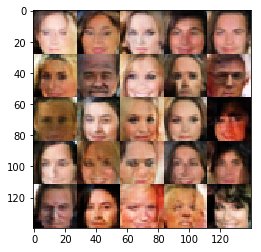

Epoch 1/1... Batch 0/32... Discriminator Loss: 1.3315... Generator Loss: 0.7176
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.3097... Generator Loss: 1.3740
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.2096... Generator Loss: 1.1137
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.3126... Generator Loss: 0.7210
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2417... Generator Loss: 0.8032
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.1924... Generator Loss: 0.8488
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.1900... Generator Loss: 0.8984
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.3502... Generator Loss: 0.5630
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.2998... Generator Loss: 0.6182
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.5263... Generator Loss: 0.4508


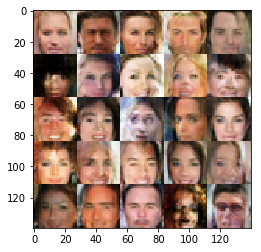

Epoch 1/1... Batch 4/32... Discriminator Loss: 1.2294... Generator Loss: 0.8021
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.3695... Generator Loss: 0.5602
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2846... Generator Loss: 0.7091
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.3337... Generator Loss: 1.3539
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2528... Generator Loss: 0.7562
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.1661... Generator Loss: 0.8906
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.2170... Generator Loss: 1.0807
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.3024... Generator Loss: 0.6979
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.3070... Generator Loss: 0.7440
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2425... Generator Loss: 0.9278


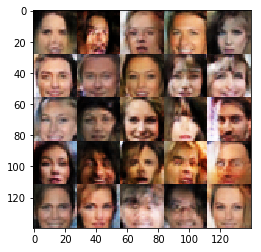

Epoch 1/1... Batch 8/32... Discriminator Loss: 1.3378... Generator Loss: 0.7476
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.3341... Generator Loss: 0.6531
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.3199... Generator Loss: 0.5887
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.2885... Generator Loss: 0.8096
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.1526... Generator Loss: 1.0596
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2324... Generator Loss: 1.0295
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.2549... Generator Loss: 0.7370
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2147... Generator Loss: 0.7988
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.1907... Generator Loss: 0.9125
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.1826... Generator Loss: 0.9140


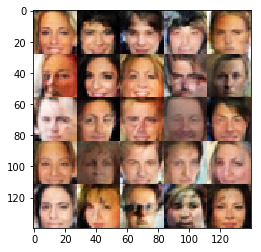

Epoch 1/1... Batch 12/32... Discriminator Loss: 1.3867... Generator Loss: 0.5940
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.2002... Generator Loss: 0.9038
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.1576... Generator Loss: 0.9034
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2106... Generator Loss: 0.8655
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.2173... Generator Loss: 1.0606
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2590... Generator Loss: 0.8166
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2989... Generator Loss: 0.6934
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2467... Generator Loss: 0.8010
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.1775... Generator Loss: 0.8501
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.1518... Generator Loss: 0.8977


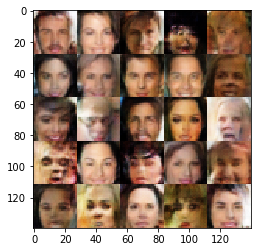

Epoch 1/1... Batch 16/32... Discriminator Loss: 1.1281... Generator Loss: 1.2177
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2149... Generator Loss: 1.2579
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.2788... Generator Loss: 0.8906
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2934... Generator Loss: 1.0257
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2593... Generator Loss: 1.0620
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.1962... Generator Loss: 1.0491
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.1429... Generator Loss: 0.9652
Epoch 1/1... Batch 22/32... Discriminator Loss: 4.8682... Generator Loss: 0.1369
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.3752... Generator Loss: 0.6504
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2760... Generator Loss: 0.8337


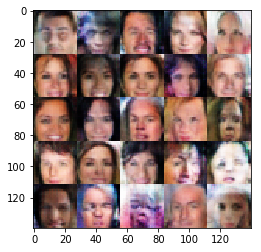

Epoch 1/1... Batch 20/32... Discriminator Loss: 1.2295... Generator Loss: 0.8874
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2394... Generator Loss: 0.8129
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2171... Generator Loss: 0.8572
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.1835... Generator Loss: 0.8232
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.1854... Generator Loss: 0.8418
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.1578... Generator Loss: 0.8094
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.1845... Generator Loss: 0.8785
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2361... Generator Loss: 0.8562
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.2514... Generator Loss: 0.7925
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2220... Generator Loss: 0.8023


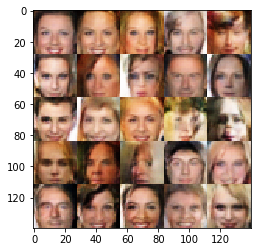

Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2905... Generator Loss: 0.7948
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.1756... Generator Loss: 0.8916
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2764... Generator Loss: 0.7711
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.2894... Generator Loss: 0.8062
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.1870... Generator Loss: 0.7788
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2316... Generator Loss: 0.9681
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.1550... Generator Loss: 0.8532
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2509... Generator Loss: 0.6685
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.1825... Generator Loss: 0.9470
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.1623... Generator Loss: 0.9276


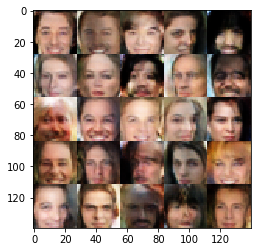

Epoch 1/1... Batch 28/32... Discriminator Loss: 1.1767... Generator Loss: 0.8149
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.3314... Generator Loss: 0.7360
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.2063... Generator Loss: 0.7980
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2479... Generator Loss: 0.7649
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.1901... Generator Loss: 0.8630
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.5851... Generator Loss: 0.3903
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2720... Generator Loss: 0.6856
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.2674... Generator Loss: 0.7730
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2394... Generator Loss: 1.0201
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.1896... Generator Loss: 0.9096


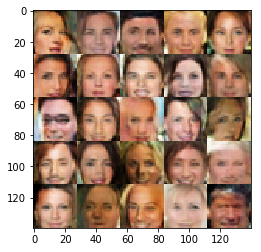

Epoch 1/1... Batch 0/32... Discriminator Loss: 1.2154... Generator Loss: 0.8721
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2320... Generator Loss: 0.7388
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.1982... Generator Loss: 0.9402
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2303... Generator Loss: 0.7498
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2017... Generator Loss: 1.0123
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.1824... Generator Loss: 0.9717
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.2235... Generator Loss: 0.8640
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.3756... Generator Loss: 0.5620
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.1871... Generator Loss: 0.9191
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.1690... Generator Loss: 1.0195


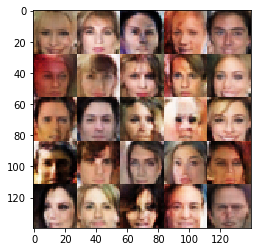

Epoch 1/1... Batch 4/32... Discriminator Loss: 1.1613... Generator Loss: 0.8762
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.3313... Generator Loss: 0.7254
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.1942... Generator Loss: 0.8021
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.1994... Generator Loss: 0.9973
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2401... Generator Loss: 0.8944
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.2988... Generator Loss: 0.7067
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.1903... Generator Loss: 1.1969
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.0625... Generator Loss: 0.9897
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.3073... Generator Loss: 0.5926
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2472... Generator Loss: 0.6596


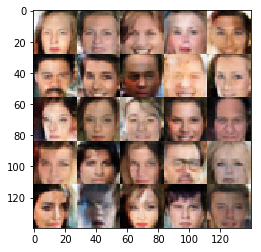

Epoch 1/1... Batch 8/32... Discriminator Loss: 1.3400... Generator Loss: 0.6122
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2183... Generator Loss: 0.8534
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.1513... Generator Loss: 0.8827
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.2301... Generator Loss: 1.4559
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.3458... Generator Loss: 0.6573
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2950... Generator Loss: 0.6001
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.2539... Generator Loss: 0.8981
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.3203... Generator Loss: 0.7019
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2820... Generator Loss: 1.2395
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.2746... Generator Loss: 0.9782


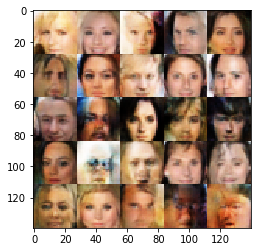

Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2635... Generator Loss: 0.7790
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.3119... Generator Loss: 0.8785
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.3200... Generator Loss: 0.8457
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.3269... Generator Loss: 0.5421
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.1603... Generator Loss: 0.7726
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.1688... Generator Loss: 0.9597
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2241... Generator Loss: 0.9736
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2596... Generator Loss: 0.8530
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.3486... Generator Loss: 0.5529
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.1550... Generator Loss: 0.8838


Epoch 1/1... Batch 16/32... Discriminator Loss: 1.1141... Generator Loss: 1.0068
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2714... Generator Loss: 1.0480
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.2184... Generator Loss: 0.8798
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.1994... Generator Loss: 0.8934
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.1365... Generator Loss: 1.0865
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.2099... Generator Loss: 0.7584
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2075... Generator Loss: 1.2999
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.1883... Generator Loss: 0.8210
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.2622... Generator Loss: 0.6927
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2171... Generator Loss: 0.8550


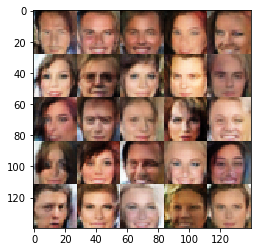

Epoch 1/1... Batch 20/32... Discriminator Loss: 1.3044... Generator Loss: 0.6534
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2277... Generator Loss: 1.0687
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2014... Generator Loss: 0.9725
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2977... Generator Loss: 0.6634
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.4771... Generator Loss: 0.5334
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.1855... Generator Loss: 0.7494
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.1921... Generator Loss: 0.7719
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.3126... Generator Loss: 0.6080
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.2503... Generator Loss: 0.7340
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2444... Generator Loss: 0.7910


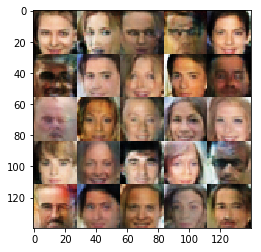

Epoch 1/1... Batch 24/32... Discriminator Loss: 1.1907... Generator Loss: 0.8686
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.1609... Generator Loss: 0.9688
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2939... Generator Loss: 0.6710
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.2187... Generator Loss: 0.7910
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.2875... Generator Loss: 0.7769
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.1516... Generator Loss: 0.8288
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.2480... Generator Loss: 0.8180
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2386... Generator Loss: 0.8521
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.3152... Generator Loss: 1.3339
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2256... Generator Loss: 0.8360


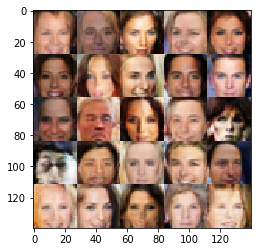

Epoch 1/1... Batch 28/32... Discriminator Loss: 1.1461... Generator Loss: 0.9428
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.2276... Generator Loss: 0.9570
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.2341... Generator Loss: 1.0918
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2052... Generator Loss: 0.9276
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.1817... Generator Loss: 0.7635
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2256... Generator Loss: 1.0707
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2526... Generator Loss: 0.8092
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.2942... Generator Loss: 0.5991
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.3674... Generator Loss: 0.5453
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.2732... Generator Loss: 0.7228


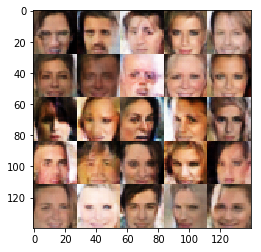

Epoch 1/1... Batch 0/32... Discriminator Loss: 1.1990... Generator Loss: 0.8417
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2239... Generator Loss: 0.7631
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.3265... Generator Loss: 0.6079
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2271... Generator Loss: 0.7615
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2155... Generator Loss: 0.7551
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.1778... Generator Loss: 0.9771
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.2439... Generator Loss: 0.8062
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.5089... Generator Loss: 0.4900
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.2437... Generator Loss: 0.7691
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.1336... Generator Loss: 0.9454


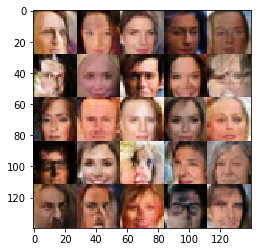

Epoch 1/1... Batch 4/32... Discriminator Loss: 1.2804... Generator Loss: 0.7585
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2456... Generator Loss: 0.8448
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2186... Generator Loss: 0.7654
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.3123... Generator Loss: 1.5005
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2658... Generator Loss: 0.6800
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.2738... Generator Loss: 0.6454
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.2296... Generator Loss: 0.7648
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2103... Generator Loss: 0.8670
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.2809... Generator Loss: 0.6281
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2280... Generator Loss: 0.7758


Epoch 1/1... Batch 8/32... Discriminator Loss: 1.2337... Generator Loss: 1.2490
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2424... Generator Loss: 0.9812
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.1590... Generator Loss: 0.8726
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.2311... Generator Loss: 0.9163
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.2354... Generator Loss: 0.7367
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2238... Generator Loss: 0.7296
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.3182... Generator Loss: 0.6821
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2689... Generator Loss: 1.1231
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2158... Generator Loss: 1.1733
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.3837... Generator Loss: 0.5714


Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2691... Generator Loss: 0.7041
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.2077... Generator Loss: 1.2842
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.1619... Generator Loss: 0.9349
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.2295... Generator Loss: 0.8877
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.1715... Generator Loss: 1.0582
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2085... Generator Loss: 0.8360
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.1454... Generator Loss: 1.1628
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.1659... Generator Loss: 0.8699
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.1602... Generator Loss: 0.7812
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.5361... Generator Loss: 0.4751


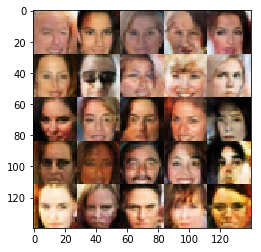

Epoch 1/1... Batch 16/32... Discriminator Loss: 1.1968... Generator Loss: 0.7677
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2178... Generator Loss: 0.8917
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.1791... Generator Loss: 1.0289
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.1457... Generator Loss: 1.0523
Epoch 1/1... Batch 24/32... Discriminator Loss: 1.1395... Generator Loss: 0.8733
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.2344... Generator Loss: 0.7346
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.2960... Generator Loss: 1.5993
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.1417... Generator Loss: 0.9213
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.2331... Generator Loss: 0.7507
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.1887... Generator Loss: 0.8445


Epoch 1/1... Batch 20/32... Discriminator Loss: 1.1706... Generator Loss: 0.9115
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.2355... Generator Loss: 0.9906
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.1534... Generator Loss: 1.0749
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2347... Generator Loss: 1.2586
Epoch 1/1... Batch 28/32... Discriminator Loss: 1.1767... Generator Loss: 0.8665
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.2671... Generator Loss: 0.8332
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.1324... Generator Loss: 1.2327
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.2205... Generator Loss: 0.9996
Epoch 1/1... Batch 4/32... Discriminator Loss: 1.1586... Generator Loss: 1.0144
Epoch 1/1... Batch 14/32... Discriminator Loss: 1.2691... Generator Loss: 0.7334


Epoch 1/1... Batch 24/32... Discriminator Loss: 1.2623... Generator Loss: 1.0942
Epoch 1/1... Batch 2/32... Discriminator Loss: 1.1882... Generator Loss: 0.9783
Epoch 1/1... Batch 12/32... Discriminator Loss: 1.1638... Generator Loss: 0.8036
Epoch 1/1... Batch 22/32... Discriminator Loss: 1.3347... Generator Loss: 1.2044
Epoch 1/1... Batch 0/32... Discriminator Loss: 1.1984... Generator Loss: 0.6519
Epoch 1/1... Batch 10/32... Discriminator Loss: 1.3282... Generator Loss: 0.6081
Epoch 1/1... Batch 20/32... Discriminator Loss: 1.2327... Generator Loss: 1.3731
Epoch 1/1... Batch 30/32... Discriminator Loss: 1.1645... Generator Loss: 0.7556
Epoch 1/1... Batch 8/32... Discriminator Loss: 1.1575... Generator Loss: 0.8572
Epoch 1/1... Batch 18/32... Discriminator Loss: 1.2579... Generator Loss: 0.9328


Epoch 1/1... Batch 28/32... Discriminator Loss: 1.1889... Generator Loss: 0.7544
Epoch 1/1... Batch 6/32... Discriminator Loss: 1.2375... Generator Loss: 0.7397
Epoch 1/1... Batch 16/32... Discriminator Loss: 1.1314... Generator Loss: 0.8732
Epoch 1/1... Batch 26/32... Discriminator Loss: 1.1913... Generator Loss: 0.8790


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.